In [1]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from models_unet_2 import Discriminator, Generator, initialize_weights
import torch.optim as optim
import torchvision
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt
from PIL import Image
import math

C:\Users\Mateusz\anaconda3\envs\pytorch_11_2022\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from color_torch import rgb2hsv_torch
from color_torch import hsv2rgb_torch

In [3]:
IMAGE_SIZE = 128
CHANNELS_IMG = 3
BATCH_SIZE = 64
LEARNING_RATE = 8e-4
EPOCHS = 5
Z_DIM = 100
FILTERS = 32

In [4]:
# dataset_path = "D:\\Desktop_D\\Workspace\\Moje\\ML\\allfaces\\dataset"
dataset_path = r'D:\Desktop_D\Workspace\Moje\ML\allfaces\dataset'

In [5]:
transforms = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)

In [6]:
dataset = datasets.ImageFolder(root=dataset_path, transform=transforms)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
disc = Discriminator(CHANNELS_IMG+1, FILTERS).to(device)
gen = Generator(1,CHANNELS_IMG, FILTERS).to(device)
initialize_weights(gen)
initialize_weights(disc)

In [9]:
opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.5, 0.999))
# criterion = nn.BCELoss()
criterion = nn.MSELoss()

In [10]:
writer_fake = SummaryWriter(f"logs/fake")

In [11]:
disc.train()
gen.train()

Generator(
  (enc1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (enc4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (dec0): Seq

In [12]:
fixed_noise = torch.randn(32, Z_DIM, 1, 1).to(device)

In [13]:
fixed_noise = next(iter(dataloader))[0][:32].to(device)
fixed_noise_rgb = fixed_noise
fixed_noise = fixed_noise.mean(dim=1, keepdim=True)

In [14]:
def count_parameters_per_layer(model):
    for name, param in model.named_parameters():
        print(f"{name}: {param.numel()}")

In [15]:
count_parameters_per_layer(disc)

disc.0.weight: 3200
disc.0.bias: 32
disc.1.weight: 9216
disc.1.bias: 32
disc.3.0.weight: 18432
disc.3.0.bias: 64
disc.3.1.weight: 64
disc.3.1.bias: 64
disc.4.0.weight: 73728
disc.4.0.bias: 128
disc.4.1.weight: 128
disc.4.1.bias: 128
disc.5.0.weight: 294912
disc.5.0.bias: 256
disc.5.1.weight: 256
disc.5.1.bias: 256
disc.6.weight: 2304
disc.6.bias: 1


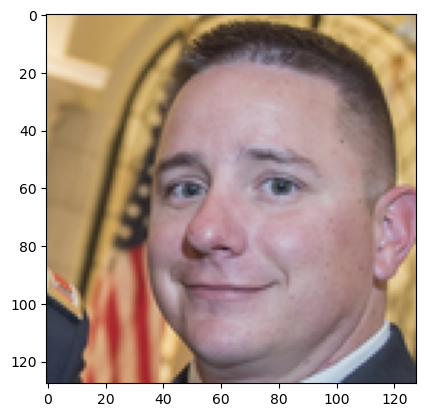

In [16]:
fixed_noise_cpu = fixed_noise_rgb[1].cpu().detach().numpy()  # Copy the first image tensor to host memory and convert it to a NumPy array
fixed_noise_cpu = (fixed_noise_cpu + 1) / 2  # Normalize the image to [0, 1] range
fixed_noise_cpu = fixed_noise_cpu.transpose(1, 2, 0)  # Change the shape from (3, 64, 64) to (64, 64, 3)

plt.imshow(fixed_noise_cpu)

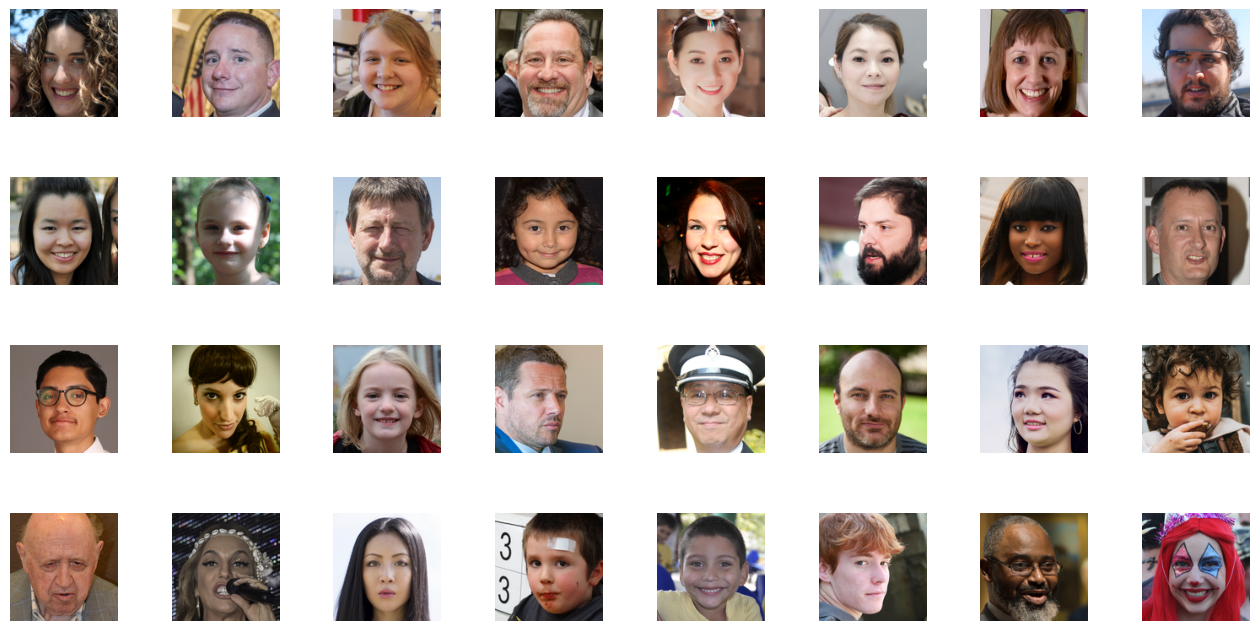

In [17]:
n_images = 32
rows = 4
cols = 8

fig, axs = plt.subplots(rows, cols, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

for i in range(n_images):
    img = fixed_noise_rgb[i].cpu().detach().numpy()
    img = (img + 1) / 2  # Normalize the image to [0, 1] range
    img = img.transpose(1, 2, 0)  # Change the shape from (3, 64, 64) to (64, 64, 3)
    
    ax = axs[i // cols, i % cols]
    ax.imshow(img)
    ax.axis('off')

plt.show()

In [18]:
def callback(epoch, batch_idx, loss_disc, loss_gen, gen, step):
    print(
        f"Epoch [{epoch}/{EPOCHS}] Batch {batch_idx}/{len(dataloader)} \
          Loss D: {loss_disc:.4f}, loss G: {loss_gen:.4f}"
    )

    with torch.no_grad():
        fake = gen(fixed_noise)
        img_grid_fake = torchvision.utils.make_grid(fake[:32], normalize=True)
        writer_fake.add_image("Fake", img_grid_fake, global_step=step)

In [19]:
def tensor_hs_to_hsv(predicted_hs):
    cos_h, sin_h, s_channel = predicted_hs[:, 0:1, :, :], predicted_hs[:, 1:2, :, :], predicted_hs[:, 2:3, :, :]
    h_channel = torch.atan2(sin_h, cos_h) / (2 * math.pi) % 1.0
    hsv_image = torch.cat((h_channel, s_channel), dim=1)
    return hsv_image

In [117]:
step = 900
EPOCHS=500
loss_disc = 0
for epoch in range(EPOCHS):
    for batch_idx, (real_images, _) in enumerate(dataloader):
        gray_images = real_images.mean(dim=1, keepdim=True)

        gray_images = gray_images.to(device)
        real_images = real_images.to(device)
        fake_images = gen(gray_images)
        
        # Train disc
#         disc_input_real = torch.cat((real_images, gray_images), dim=1)
#         disc_input_fake = torch.cat((fake_images.detach(), gray_images), dim=1)
#         disc_real = disc(disc_input_real).reshape(-1)
#         loss_disc_real = criterion(disc_real, torch.ones_like(disc_real))
#         disc_fake = disc(disc_input_fake).reshape(-1)
#         loss_disc_fake = criterion(disc_fake, torch.zeros_like(disc_fake))
#         loss_disc = (loss_disc_real + loss_disc_fake) / 2
#         disc.zero_grad()
#         loss_disc.backward()
#         opt_disc.step()
        
        # Train generator
#         output = disc(torch.cat((fake_images, gray_images), dim=1)).reshape(-1)
#         loss_gen = criterion(output, torch.ones_like(output))
        loss_gen = criterion(fake_images, real_images)

        gen.zero_grad()
        loss_gen.backward()
        opt_gen.step()
        if batch_idx % 10 == 0:
            print("asd")
            callback(epoch, batch_idx, loss_disc, loss_gen, gen, step)
            step += 1

asd
Epoch [0/500] Batch 0/1096           Loss D: 0.0000, loss G: 0.0136
asd
Epoch [0/500] Batch 10/1096           Loss D: 0.0000, loss G: 0.0192
asd
Epoch [0/500] Batch 20/1096           Loss D: 0.0000, loss G: 0.0152
asd
Epoch [0/500] Batch 30/1096           Loss D: 0.0000, loss G: 0.0188
asd
Epoch [0/500] Batch 40/1096           Loss D: 0.0000, loss G: 0.0146
asd
Epoch [0/500] Batch 50/1096           Loss D: 0.0000, loss G: 0.0149
asd
Epoch [0/500] Batch 60/1096           Loss D: 0.0000, loss G: 0.0202
asd
Epoch [0/500] Batch 70/1096           Loss D: 0.0000, loss G: 0.0208
asd
Epoch [0/500] Batch 80/1096           Loss D: 0.0000, loss G: 0.0120
asd
Epoch [0/500] Batch 90/1096           Loss D: 0.0000, loss G: 0.0169
asd
Epoch [0/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0166
asd
Epoch [0/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0218
asd
Epoch [0/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0143
asd
Epoch [0/500] Batch 130/1096           Loss D

asd
Epoch [1/500] Batch 10/1096           Loss D: 0.0000, loss G: 0.0175
asd
Epoch [1/500] Batch 20/1096           Loss D: 0.0000, loss G: 0.0153
asd
Epoch [1/500] Batch 30/1096           Loss D: 0.0000, loss G: 0.0145
asd
Epoch [1/500] Batch 40/1096           Loss D: 0.0000, loss G: 0.0178
asd
Epoch [1/500] Batch 50/1096           Loss D: 0.0000, loss G: 0.0205
asd
Epoch [1/500] Batch 60/1096           Loss D: 0.0000, loss G: 0.0176
asd
Epoch [1/500] Batch 70/1096           Loss D: 0.0000, loss G: 0.0155
asd
Epoch [1/500] Batch 80/1096           Loss D: 0.0000, loss G: 0.0176
asd
Epoch [1/500] Batch 90/1096           Loss D: 0.0000, loss G: 0.0135
asd
Epoch [1/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0168
asd
Epoch [1/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0207
asd
Epoch [1/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0220
asd
Epoch [1/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0146
asd
Epoch [1/500] Batch 140/1096           Loss

asd
Epoch [2/500] Batch 20/1096           Loss D: 0.0000, loss G: 0.0146
asd
Epoch [2/500] Batch 30/1096           Loss D: 0.0000, loss G: 0.0138
asd
Epoch [2/500] Batch 40/1096           Loss D: 0.0000, loss G: 0.0148
asd
Epoch [2/500] Batch 50/1096           Loss D: 0.0000, loss G: 0.0122
asd
Epoch [2/500] Batch 60/1096           Loss D: 0.0000, loss G: 0.0148
asd
Epoch [2/500] Batch 70/1096           Loss D: 0.0000, loss G: 0.0176
asd
Epoch [2/500] Batch 80/1096           Loss D: 0.0000, loss G: 0.0154
asd
Epoch [2/500] Batch 90/1096           Loss D: 0.0000, loss G: 0.0160
asd
Epoch [2/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0200
asd
Epoch [2/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0147
asd
Epoch [2/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0165
asd
Epoch [2/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0189
asd
Epoch [2/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0185
asd
Epoch [2/500] Batch 150/1096           Los

asd
Epoch [3/500] Batch 30/1096           Loss D: 0.0000, loss G: 0.0192
asd
Epoch [3/500] Batch 40/1096           Loss D: 0.0000, loss G: 0.0149
asd
Epoch [3/500] Batch 50/1096           Loss D: 0.0000, loss G: 0.0176
asd
Epoch [3/500] Batch 60/1096           Loss D: 0.0000, loss G: 0.0181
asd
Epoch [3/500] Batch 70/1096           Loss D: 0.0000, loss G: 0.0182
asd
Epoch [3/500] Batch 80/1096           Loss D: 0.0000, loss G: 0.0153
asd
Epoch [3/500] Batch 90/1096           Loss D: 0.0000, loss G: 0.0152
asd
Epoch [3/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0156
asd
Epoch [3/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0167
asd
Epoch [3/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0158
asd
Epoch [3/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0176
asd
Epoch [3/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0140
asd
Epoch [3/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0137
asd
Epoch [3/500] Batch 160/1096           Lo

asd
Epoch [4/500] Batch 40/1096           Loss D: 0.0000, loss G: 0.0161
asd
Epoch [4/500] Batch 50/1096           Loss D: 0.0000, loss G: 0.0122
asd
Epoch [4/500] Batch 60/1096           Loss D: 0.0000, loss G: 0.0180
asd
Epoch [4/500] Batch 70/1096           Loss D: 0.0000, loss G: 0.0156
asd
Epoch [4/500] Batch 80/1096           Loss D: 0.0000, loss G: 0.0159
asd
Epoch [4/500] Batch 90/1096           Loss D: 0.0000, loss G: 0.0141
asd
Epoch [4/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0151
asd
Epoch [4/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0193
asd
Epoch [4/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0182
asd
Epoch [4/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0135
asd
Epoch [4/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0139
asd
Epoch [4/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0141
asd
Epoch [4/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0153
asd
Epoch [4/500] Batch 170/1096           L

asd
Epoch [5/500] Batch 50/1096           Loss D: 0.0000, loss G: 0.0189
asd
Epoch [5/500] Batch 60/1096           Loss D: 0.0000, loss G: 0.0192
asd
Epoch [5/500] Batch 70/1096           Loss D: 0.0000, loss G: 0.0147
asd
Epoch [5/500] Batch 80/1096           Loss D: 0.0000, loss G: 0.0143
asd
Epoch [5/500] Batch 90/1096           Loss D: 0.0000, loss G: 0.0150
asd
Epoch [5/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0149
asd
Epoch [5/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0130
asd
Epoch [5/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0145
asd
Epoch [5/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0157
asd
Epoch [5/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0157
asd
Epoch [5/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0161
asd
Epoch [5/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0150
asd
Epoch [5/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0166
asd
Epoch [5/500] Batch 180/1096           

asd
Epoch [6/500] Batch 60/1096           Loss D: 0.0000, loss G: 0.0193
asd
Epoch [6/500] Batch 70/1096           Loss D: 0.0000, loss G: 0.0150
asd
Epoch [6/500] Batch 80/1096           Loss D: 0.0000, loss G: 0.0151
asd
Epoch [6/500] Batch 90/1096           Loss D: 0.0000, loss G: 0.0151
asd
Epoch [6/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0153
asd
Epoch [6/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0184
asd
Epoch [6/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0161
asd
Epoch [6/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0161
asd
Epoch [6/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0147
asd
Epoch [6/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0167
asd
Epoch [6/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0184
asd
Epoch [6/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0181
asd
Epoch [6/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0163
asd
Epoch [6/500] Batch 190/1096          

asd
Epoch [7/500] Batch 70/1096           Loss D: 0.0000, loss G: 0.0116
asd
Epoch [7/500] Batch 80/1096           Loss D: 0.0000, loss G: 0.0146
asd
Epoch [7/500] Batch 90/1096           Loss D: 0.0000, loss G: 0.0168
asd
Epoch [7/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0184
asd
Epoch [7/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0159
asd
Epoch [7/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0120
asd
Epoch [7/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0171
asd
Epoch [7/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0163
asd
Epoch [7/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0145
asd
Epoch [7/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0161
asd
Epoch [7/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0159
asd
Epoch [7/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0150
asd
Epoch [7/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0176
asd
Epoch [7/500] Batch 200/1096         

asd
Epoch [8/500] Batch 80/1096           Loss D: 0.0000, loss G: 0.0135
asd
Epoch [8/500] Batch 90/1096           Loss D: 0.0000, loss G: 0.0137
asd
Epoch [8/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0142
asd
Epoch [8/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0169
asd
Epoch [8/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0139
asd
Epoch [8/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0163
asd
Epoch [8/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0145
asd
Epoch [8/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0120
asd
Epoch [8/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0125
asd
Epoch [8/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0136
asd
Epoch [8/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0148
asd
Epoch [8/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0155
asd
Epoch [8/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0180
asd
Epoch [8/500] Batch 210/1096        

asd
Epoch [9/500] Batch 90/1096           Loss D: 0.0000, loss G: 0.0138
asd
Epoch [9/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0132
asd
Epoch [9/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0147
asd
Epoch [9/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0143
asd
Epoch [9/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0151
asd
Epoch [9/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0164
asd
Epoch [9/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0154
asd
Epoch [9/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0165
asd
Epoch [9/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0147
asd
Epoch [9/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0128
asd
Epoch [9/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0155
asd
Epoch [9/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0140
asd
Epoch [9/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0138
asd
Epoch [9/500] Batch 220/1096       

asd
Epoch [10/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0120
asd
Epoch [10/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0144
asd
Epoch [10/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0144
asd
Epoch [10/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0163
asd
Epoch [10/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0142
asd
Epoch [10/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0136
asd
Epoch [10/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0147
asd
Epoch [10/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0108
asd
Epoch [10/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0141
asd
Epoch [10/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0152
asd
Epoch [10/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0144
asd
Epoch [10/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0150
asd
Epoch [10/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0159
asd
Epoch [10/500] Batch 

asd
Epoch [11/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0123
asd
Epoch [11/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0168
asd
Epoch [11/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0155
asd
Epoch [11/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0140
asd
Epoch [11/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0137
asd
Epoch [11/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0144
asd
Epoch [11/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0151
asd
Epoch [11/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0141
asd
Epoch [11/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0129
asd
Epoch [11/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0118
asd
Epoch [11/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0121
asd
Epoch [11/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0114
asd
Epoch [11/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0131
asd
Epoch [11/500] Batch 

asd
Epoch [12/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0160
asd
Epoch [12/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0137
asd
Epoch [12/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0166
asd
Epoch [12/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0140
asd
Epoch [12/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0123
asd
Epoch [12/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0125
asd
Epoch [12/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0131
asd
Epoch [12/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0132
asd
Epoch [12/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0155
asd
Epoch [12/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0156
asd
Epoch [12/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0148
asd
Epoch [12/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0125
asd
Epoch [12/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0160
asd
Epoch [12/500] Batch 

asd
Epoch [13/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0123
asd
Epoch [13/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0136
asd
Epoch [13/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0134
asd
Epoch [13/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0124
asd
Epoch [13/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0146
asd
Epoch [13/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0130
asd
Epoch [13/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0126
asd
Epoch [13/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0127
asd
Epoch [13/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0171
asd
Epoch [13/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0140
asd
Epoch [13/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0171
asd
Epoch [13/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0107
asd
Epoch [13/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0167
asd
Epoch [13/500] Batch 

asd
Epoch [14/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0143
asd
Epoch [14/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0124
asd
Epoch [14/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0118
asd
Epoch [14/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0159
asd
Epoch [14/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0169
asd
Epoch [14/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0157
asd
Epoch [14/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0127
asd
Epoch [14/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0146
asd
Epoch [14/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0118
asd
Epoch [14/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0134
asd
Epoch [14/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0135
asd
Epoch [14/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0103
asd
Epoch [14/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0131
asd
Epoch [14/500] Batch 

asd
Epoch [15/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0131
asd
Epoch [15/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0134
asd
Epoch [15/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0130
asd
Epoch [15/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0134
asd
Epoch [15/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0139
asd
Epoch [15/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0134
asd
Epoch [15/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0120
asd
Epoch [15/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0130
asd
Epoch [15/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0115
asd
Epoch [15/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0112
asd
Epoch [15/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0141
asd
Epoch [15/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0124
asd
Epoch [15/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0128
asd
Epoch [15/500] Batch 

asd
Epoch [16/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0143
asd
Epoch [16/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0162
asd
Epoch [16/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0144
asd
Epoch [16/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0105
asd
Epoch [16/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0138
asd
Epoch [16/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0120
asd
Epoch [16/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0168
asd
Epoch [16/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0173
asd
Epoch [16/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0140
asd
Epoch [16/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0137
asd
Epoch [16/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0129
asd
Epoch [16/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0150
asd
Epoch [16/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0131
asd
Epoch [16/500] Batch 

asd
Epoch [17/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0144
asd
Epoch [17/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0127
asd
Epoch [17/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0126
asd
Epoch [17/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0113
asd
Epoch [17/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0155
asd
Epoch [17/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0139
asd
Epoch [17/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0120
asd
Epoch [17/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0135
asd
Epoch [17/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0131
asd
Epoch [17/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0144
asd
Epoch [17/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0118
asd
Epoch [17/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0124
asd
Epoch [17/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0117
asd
Epoch [17/500] Batch 

asd
Epoch [18/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0112
asd
Epoch [18/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0121
asd
Epoch [18/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0137
asd
Epoch [18/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0122
asd
Epoch [18/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0135
asd
Epoch [18/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0132
asd
Epoch [18/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0137
asd
Epoch [18/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0128
asd
Epoch [18/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0127
asd
Epoch [18/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0129
asd
Epoch [18/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0147
asd
Epoch [18/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0142
asd
Epoch [18/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0122
asd
Epoch [18/500] Batch 

asd
Epoch [19/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0121
asd
Epoch [19/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0140
asd
Epoch [19/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0147
asd
Epoch [19/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0135
asd
Epoch [19/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0142
asd
Epoch [19/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0129
asd
Epoch [19/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0133
asd
Epoch [19/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0121
asd
Epoch [19/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0144
asd
Epoch [19/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0135
asd
Epoch [19/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0127
asd
Epoch [19/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0133
asd
Epoch [19/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0105
asd
Epoch [19/500] Batch 

asd
Epoch [20/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0106
asd
Epoch [20/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0128
asd
Epoch [20/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0121
asd
Epoch [20/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0135
asd
Epoch [20/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0118
asd
Epoch [20/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0124
asd
Epoch [20/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0138
asd
Epoch [20/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0115
asd
Epoch [20/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0112
asd
Epoch [20/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0125
asd
Epoch [20/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0156
asd
Epoch [20/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0128
asd
Epoch [20/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0164
asd
Epoch [20/500] Batch 

asd
Epoch [21/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0125
asd
Epoch [21/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0131
asd
Epoch [21/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0124
asd
Epoch [21/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0146
asd
Epoch [21/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0116
asd
Epoch [21/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0117
asd
Epoch [21/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0121
asd
Epoch [21/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0110
asd
Epoch [21/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0124
asd
Epoch [21/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0128
asd
Epoch [21/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0131
asd
Epoch [21/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0123
asd
Epoch [21/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0153
asd
Epoch [21/500] Batch 

asd
Epoch [22/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0124
asd
Epoch [22/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0143
asd
Epoch [22/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0115
asd
Epoch [22/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0123
asd
Epoch [22/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0109
asd
Epoch [22/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0111
asd
Epoch [22/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0152
asd
Epoch [22/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0148
asd
Epoch [22/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0117
asd
Epoch [22/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0122
asd
Epoch [22/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0139
asd
Epoch [22/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0125
asd
Epoch [22/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0153
asd
Epoch [22/500] Batch 

asd
Epoch [23/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0138
asd
Epoch [23/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0133
asd
Epoch [23/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0110
asd
Epoch [23/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0143
asd
Epoch [23/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0112
asd
Epoch [23/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0138
asd
Epoch [23/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0157
asd
Epoch [23/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0117
asd
Epoch [23/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0122
asd
Epoch [23/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0129
asd
Epoch [23/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0097
asd
Epoch [23/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0142
asd
Epoch [23/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0116
asd
Epoch [23/500] Batch 

asd
Epoch [24/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0139
asd
Epoch [24/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0149
asd
Epoch [24/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0133
asd
Epoch [24/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0117
asd
Epoch [24/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0119
asd
Epoch [24/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0148
asd
Epoch [24/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0114
asd
Epoch [24/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0107
asd
Epoch [24/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0127
asd
Epoch [24/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0115
asd
Epoch [24/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0134
asd
Epoch [24/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0097
asd
Epoch [24/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0145
asd
Epoch [24/500] Batch 

asd
Epoch [25/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0111
asd
Epoch [25/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0096
asd
Epoch [25/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0121
asd
Epoch [25/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0097
asd
Epoch [25/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0116
asd
Epoch [25/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0126
asd
Epoch [25/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0130
asd
Epoch [25/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0145
asd
Epoch [25/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0138
asd
Epoch [25/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0121
asd
Epoch [25/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0113
asd
Epoch [25/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0113
asd
Epoch [25/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0111
asd
Epoch [25/500] Batch 

asd
Epoch [26/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0109
asd
Epoch [26/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0112
asd
Epoch [26/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0117
asd
Epoch [26/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0133
asd
Epoch [26/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0099
asd
Epoch [26/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0179
asd
Epoch [26/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0129
asd
Epoch [26/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0134
asd
Epoch [26/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0130
asd
Epoch [26/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0115
asd
Epoch [26/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0119
asd
Epoch [26/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0118
asd
Epoch [26/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0116
asd
Epoch [26/500] Batch 

asd
Epoch [27/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0108
asd
Epoch [27/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0123
asd
Epoch [27/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0105
asd
Epoch [27/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0093
asd
Epoch [27/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0120
asd
Epoch [27/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0103
asd
Epoch [27/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0118
asd
Epoch [27/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0116
asd
Epoch [27/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0121
asd
Epoch [27/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0106
asd
Epoch [27/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0131
asd
Epoch [27/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0136
asd
Epoch [27/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0119
asd
Epoch [27/500] Batch 

asd
Epoch [28/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0127
asd
Epoch [28/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0110
asd
Epoch [28/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0132
asd
Epoch [28/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0147
asd
Epoch [28/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0104
asd
Epoch [28/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0109
asd
Epoch [28/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0128
asd
Epoch [28/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0102
asd
Epoch [28/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0135
asd
Epoch [28/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0121
asd
Epoch [28/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0117
asd
Epoch [28/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0120
asd
Epoch [28/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0104
asd
Epoch [28/500] Batch 

asd
Epoch [29/500] Batch 100/1096           Loss D: 0.0000, loss G: 0.0116
asd
Epoch [29/500] Batch 110/1096           Loss D: 0.0000, loss G: 0.0122
asd
Epoch [29/500] Batch 120/1096           Loss D: 0.0000, loss G: 0.0132
asd
Epoch [29/500] Batch 130/1096           Loss D: 0.0000, loss G: 0.0137
asd
Epoch [29/500] Batch 140/1096           Loss D: 0.0000, loss G: 0.0125
asd
Epoch [29/500] Batch 150/1096           Loss D: 0.0000, loss G: 0.0109
asd
Epoch [29/500] Batch 160/1096           Loss D: 0.0000, loss G: 0.0124
asd
Epoch [29/500] Batch 170/1096           Loss D: 0.0000, loss G: 0.0126
asd
Epoch [29/500] Batch 180/1096           Loss D: 0.0000, loss G: 0.0132
asd
Epoch [29/500] Batch 190/1096           Loss D: 0.0000, loss G: 0.0110
asd
Epoch [29/500] Batch 200/1096           Loss D: 0.0000, loss G: 0.0134
asd
Epoch [29/500] Batch 210/1096           Loss D: 0.0000, loss G: 0.0111
asd
Epoch [29/500] Batch 220/1096           Loss D: 0.0000, loss G: 0.0121
asd
Epoch [29/500] Batch 

KeyboardInterrupt: 

In [ ]:
print(fake_images.device, real_images.device)

In [ ]:
def show_torch_image(real_images):
    fixed_noise_cpu = real_images.cpu().detach().numpy()  # Copy the first image tensor to host memory and convert it to a NumPy array
    fixed_noise_cpu = (fixed_noise_cpu + 1) / 2  # Normalize the image to [0, 1] range
    fixed_noise_cpu = fixed_noise_cpu.transpose(1, 2, 0)  # Change the shape from (3, 64, 64) to (64, 64, 3)

    plt.imshow(fixed_noise_cpu)

In [21]:
real_images = next(iter(dataloader))[0]

In [22]:
gray_images = real_images.mean(dim=1, keepdim=True).repeat(1, 3, 1, 1)

In [23]:
gray_images.shape

torch.Size([64, 3, 128, 128])

In [24]:
show_torch_image(real_images[0])

NameError: name 'show_torch_image' is not defined

In [155]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

# Load your trained model
# Make sure your model is in evaluation mode
# gen.eval()

# Function to preprocess input image
def preprocess_image(image_path, image_size=(128, 128)):
    image = Image.open(image_path).convert('RGB')
    print("SHAPE", image.size)
    print("type", type(image))
    transform = transforms.Compose(
    [
        transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.5 for _ in range(CHANNELS_IMG)], [0.5 for _ in range(CHANNELS_IMG)]
        ),
    ]
)
    return transform(image).unsqueeze(0)


# Function to postprocess the output
def postprocess_output(output_tensor):
    output_image = output_tensor.squeeze(0).detach().cpu().numpy().transpose(1, 2, 0)
    return ((output_image+1)/2 * 255).clip(0, 255).astype('uint8')



In [156]:
# Load image from disk and preprocess it
input_image_path = "00003.png"
input_image = preprocess_image(input_image_path)
gray_images = input_image.mean(dim=1, keepdim=True)

gray_images = gray_images.to(device)
# Pass the preprocessed image through the generator model
with torch.no_grad():
    output_image = gen(gray_images)

SHAPE (547, 508)
type <class 'PIL.Image.Image'>


In [150]:
output_image.shape

torch.Size([1, 3, 128, 128])

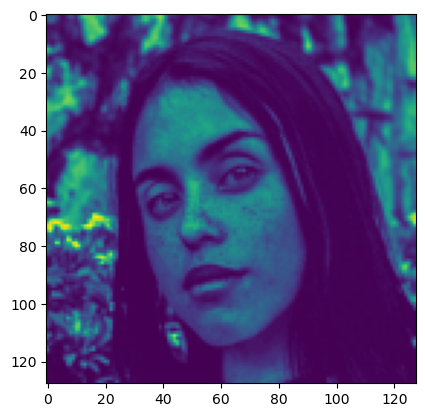

In [151]:
plt.imshow(postprocess_output(gray_images))

In [152]:
print(gray_images.max())
print(gray_images.min())
print(gray_images.mean())
print(gray_images)

tensor(0.9765, device='cuda:0')
tensor(-0.8667, device='cuda:0')
tensor(-0.5440, device='cuda:0')
tensor([[[[-0.3804, -0.4431, -0.4039,  ..., -0.1608, -0.3020, -0.2863],
          [-0.3020, -0.3020, -0.2941,  ..., -0.0118, -0.2471, -0.2784],
          [-0.3647, -0.2627, -0.3176,  ...,  0.0980, -0.1686, -0.2235],
          ...,
          [-0.8275, -0.8510, -0.8510,  ..., -0.8510, -0.8510, -0.8510],
          [-0.8431, -0.8510, -0.8510,  ..., -0.8510, -0.8510, -0.8510],
          [-0.8588, -0.8510, -0.8510,  ..., -0.8510, -0.8353, -0.8275]]]],
       device='cuda:0')


In [147]:
output_image.shape

torch.Size([1, 3, 128, 128])

In [146]:
print(output_image.max())
print(output_image.min())
print(output_image.mean())
print(output_image)

tensor(1.0000, device='cuda:0')
tensor(-0.9547, device='cuda:0')
tensor(-0.4821, device='cuda:0')
tensor([[[[-2.9085e-01, -3.6902e-01, -3.2012e-01,  ..., -5.7244e-02,
           -1.7565e-01, -1.4415e-01],
          [-2.2461e-01, -2.3766e-01, -2.1819e-01,  ...,  2.6745e-02,
           -1.8100e-01, -1.7263e-01],
          [-3.1497e-01, -1.9303e-01, -2.7254e-01,  ...,  2.1699e-01,
           -1.1652e-01, -1.0644e-01],
          ...,
          [-8.2910e-01, -8.7073e-01, -8.5603e-01,  ..., -7.8184e-01,
           -7.8741e-01, -8.0311e-01],
          [-8.5056e-01, -8.6162e-01, -8.4607e-01,  ..., -8.0518e-01,
           -7.9397e-01, -8.1195e-01],
          [-8.8566e-01, -8.6836e-01, -8.5396e-01,  ..., -7.9301e-01,
           -7.9209e-01, -7.8667e-01]],

         [[-2.7367e-01, -3.4124e-01, -2.7480e-01,  ..., -1.6171e-01,
           -3.0112e-01, -2.6148e-01],
          [-1.8565e-01, -2.0709e-01, -1.7437e-01,  ...,  4.0493e-05,
           -2.6286e-01, -2.5135e-01],
          [-2.5129e-01, -1.39

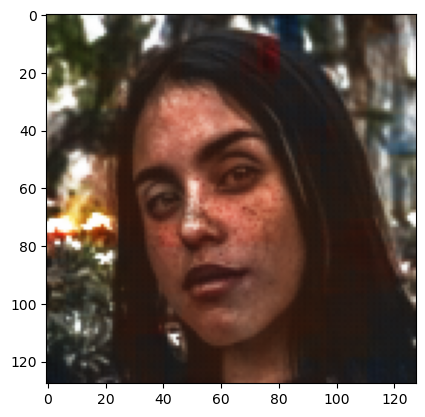

In [136]:
plt.imshow(postprocess_output(output_image))

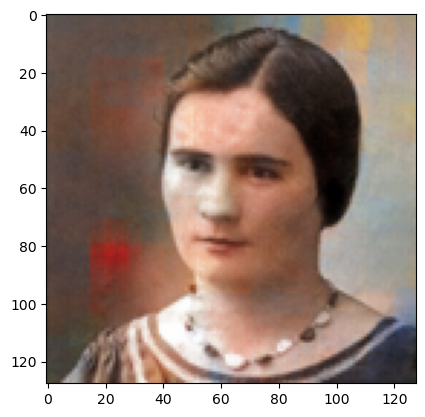

In [121]:
plt.imshow(postprocess_output(output_image))

In [127]:
torch.save(gen.state_dict(), 'generator_autoencoder_unet_128_state.pt')

In [129]:
torch.save(gen, 'generator_autoencoder_unet_128.pth')